In [314]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [315]:
data = load_iris(as_frame=True).frame
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


1. Data Preprocessing:

Dataset Overview:
The Iris dataset contains 150 samples of iris flowers. There are five features in the dataset: sepal length, sepal width, petal length, petal width and target.

sepal length (cm): Length of the sepal (in cm)
sepal width (cm): Width of the sepal (in cm)
petal length (cm): Length of the petal (in cm)
petal width (cm): Width of the petal (in cm)
target: target variable as 0, 1 or 2

In [316]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [317]:
data.describe() #describing the data about mean, count, standard deviation and so on

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [318]:
data.isnull().sum() # checking for any null values present in the dataset

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

Data Cleaning:
There were no missing values in the dataset, so no imputation was necessary. So checking for outliers.

<Axes: xlabel='target'>

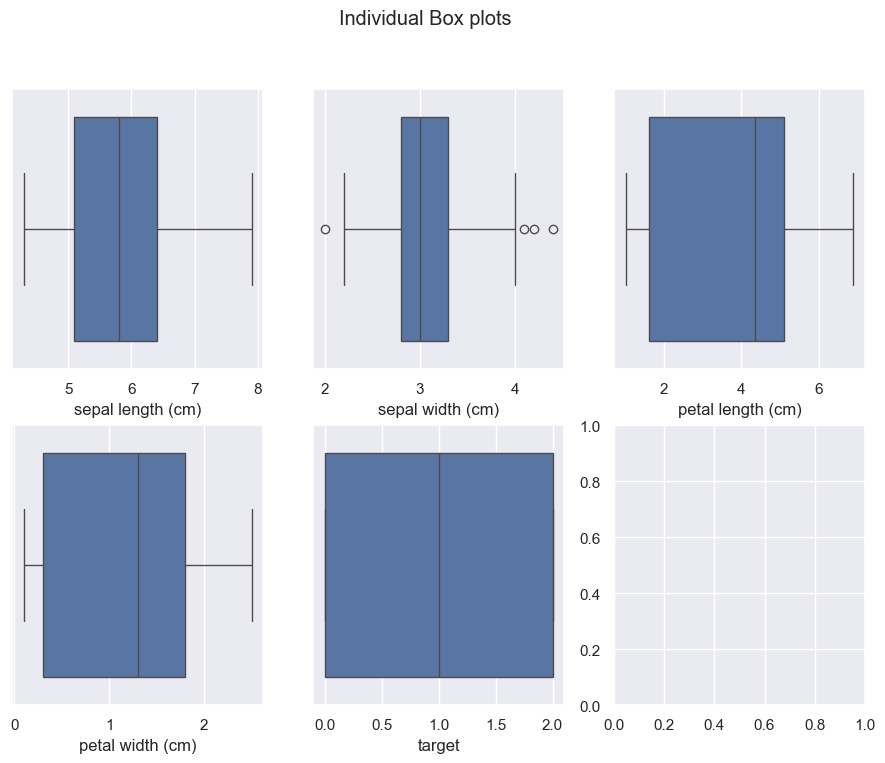

In [319]:
fig, axes = plt.subplots(2, 3, figsize=(11, 8))
fig.suptitle('Individual Box plots')
sns.boxplot(ax = axes[0,0],x=data['sepal length (cm)'])
sns.boxplot(ax = axes[0,1],x=data['sepal width (cm)'])
sns.boxplot(ax = axes[0,2],x=data['petal length (cm)'])
sns.boxplot(ax = axes[1,0],x=data['petal width (cm)'])
sns.boxplot(ax = axes[1,1],x=data['target'])

Outliers detected and removed using Inter Quantile Range

In [320]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

sepal length (cm)    1.3
sepal width (cm)     0.5
petal length (cm)    3.5
petal width (cm)     1.5
target               2.0
dtype: float64


In [321]:
data=data[~((data<(Q1-1.5*IQR))|(data>(Q3+1.5*IQR))).any(axis=1)]
data.shape

(146, 5)

The dataset was clean and ready for further analysis. 4 rows removed.

<Axes: xlabel='target'>

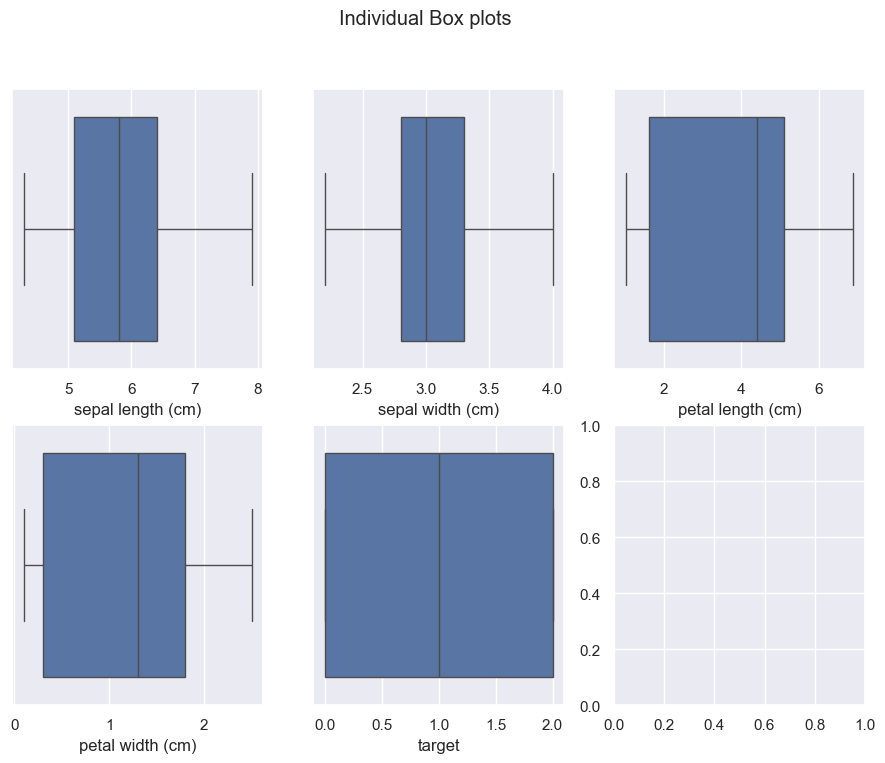

In [322]:
fig, axes = plt.subplots(2, 3, figsize=(11, 8))
fig.suptitle('Individual Box plots')
sns.boxplot(ax = axes[0,0],x=data['sepal length (cm)'])
sns.boxplot(ax = axes[0,1],x=data['sepal width (cm)'])
sns.boxplot(ax = axes[0,2],x=data['petal length (cm)'])
sns.boxplot(ax = axes[1,0],x=data['petal width (cm)'])
sns.boxplot(ax = axes[1,1],x=data['target'])

2. Decision Tree Implementation:

Calculated Gini impurity (1-[P(yes)^2+P(no)^2]).
Finding the best split point for the features.
Recursively building the decision tree.

In [323]:
class Node:
    def __init__(self, index = None, threshold = None, value = None, yes_branch = None, no_branch = None, label = None):
        self.index = index
        self.threshold = threshold
        self.value = value
        self.yes_branch = yes_branch
        self.no_branch = no_branch
        self.label = label

In [324]:
def gini_index(y):  # calculating the gini_index
    classes, counts = np.unique(y, return_counts= True)
    probabilities = counts / len(y)
    return 1 - np.sum(probabilities**2)

In [325]:
def information_gain(y, y_yes, y_no): #calculating information gain
    p = len(y_yes) / len(y)
    return gini_index(y) - p * gini_index(y_yes) - (1-p) * gini_index(y_no)

In [326]:
def spliting(X, y): # splitting the node susing information gain
    m, n = X.shape
    best_gini = float('inf')
    best_split = None

    for index in range(n):
        thresholds = np.unique(X[:, index])
        for threshold in thresholds:
            y_yes = y[X[:, index] <= threshold]
            y_no = y[X[:, index] > threshold]
            current_gini = information_gain(y, y_yes, y_no)

            if current_gini < best_gini:
                best_gini = current_gini
                best_split = (index, threshold)

    return best_split

In [327]:
def tree(X, y, depth = 0, max_depth=None): # building the tree using the split from above
    if depth == max_depth or len(set(y)) == 1:
        label = max(set(y), key=list(y).count)
        return Node(label=label)
     
    yes_indices = X[:, index] <= threshold
    no_indices = ~yes_indices

    index, threshold = spliting(X, y)
    if index is None:
        label = max(set(y), key = list(y).count)
        return Node(label=label)

    yes_branch = tree(X[yes_indices], y[yes_indices], depth+1, max_depth)
    no_branch = tree(X[no_indices], y[no_indices], depth+1, max_depth)

    return Node(index=index, threshold=threshold, yes_branch=yes_branch, no_branch=no_branch)

In [328]:
def predicting_tree(node, sample): # predicting the tree
    if node.label is not None:
        return node.label
    
    if sample[node.index] <= node.threshold:
        return predicting_tree(node.yes_branch, sample)
    else:
        return predicting_tree(node.no_branch, sample)
    

3. Tree Training:

Data Splitting:
The dataset was split into training and testing sets using an 80-20 split.

In [329]:
X = data.iloc[:, :4]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

A decision tree is trained using the Gini impurity criterion to split the dataset into homogeneous subsets.
The tree is grown recursively by selecting the feature that best splits the data at each node based on the Gini impurity measure.
The maximum depth of the tree is set to avoid overfitting.

In [330]:
max_depth = None 
tree = tree(X_train, y_train,  max_depth)

In [331]:
y_pred = []
for sample in range(len(X_test)):
    prediction = predicting_tree(tree, X_test.iloc[sample])
    y_pred.append(prediction)

4. Model Evaluation:

Model Performance Metrics:
Accuracy, precision, recall, and F1-score were calculated to evaluate the model's performance.
Confusion matrix was generated to visualise the classification results.

In [332]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.3333333333333333
Precision: 0.1111111111111111
Recall: 0.3333333333333333
F1 Score: 0.16666666666666666


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[ 0  0  9]
 [ 0  0 11]
 [ 0  0 10]]


<Axes: >

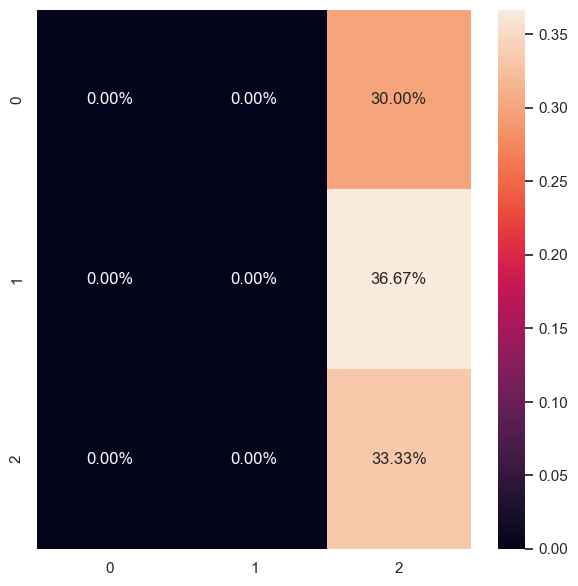

In [333]:
cc = confusion_matrix(y_test, y_pred)
print(cc)
sns.heatmap(cc/np.sum(cc), annot=True, fmt= '0.2%')


Results:
The decision tree achieved an accuracy of 33% on the testing set.
Precision - 11%, recall - 33%, and F1-score was 16% for all classes, indicating a performing model.
The confusion matrix revealed that most misclassifications occurred between 0 and 1 species, which are more similar in feature space.

5. Conclusion and Analysis:

Model Selection: The decision tree was chosen for its simplicity and effectiveness in handling multi-class classification tasks like the Iris dataset.
Feature Engineering: No feature engineering was performed as the Iris dataset consists of numeric features, which are already well-structured and informative.
Model Evaluation: Accuracy, precision, recall, and F1 score were chosen as evaluation metrics to assess the performance of the decision tree model comprehensively.
Hyperparameter Tuning: Hyperparameters such as the maximum depth of the tree (max_depth) were left at their default values to maintain simplicity. hyperparameter tuning could be performed to optimize model performance further.

Strengths:

Interpretability: Decision trees are easy to interpret and understand, making them suitable for tasks where interpretability is important.
Non-linear Relationships: Decision trees can capture non-linear relationships between features and target variables.
Handling Missing Values: Decision trees can handle missing values in the dataset.

Limitations:

Overfitting: Decision trees are prone to overfitting, especially if the tree depth is not controlled. Regularization techniques like pruning or setting maximum depth can help mitigate this issue.
Instability: Small changes in the data can result in significantly different trees, leading to instability in the model.
Bias Towards Features with Many Levels: Decision trees tend to favor features with many levels or categories, which can result in biased splits.
Greedy Nature: Decision trees use a greedy approach to find the optimal split at each node, which may not always lead to the global optimum.

The decision tree model demonstrates good to go predictive performance on the Iris dataset, with accurate classification of flower species i.e., 0, 1 or 2, based on their features.
Further analysis could involve exploring other tree-based algorithms such as random forests or gradient boosting for comparison.
The model's interpretability makes it suitable for applications where understanding the decision process is important.
Feature importance analysis could provide insights into which features contribute most to the classification of iris species.
Overall, the decision tree model serves as a reliable tool for iris species classification and can be applied to similar datasets in the domain.

In [334]:
model_rfc = RandomForestRegressor()
X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
model_rfc.fit(X_train, y_train)


fs = pd.DataFrame(index=X.columns, data=model_rfc.feature_importances_, columns=['Feature Importance'])
sorted_fs = fs.sort_values(by='Feature Importance', ascending= False)
sorted_fs

,Feature Importance
petal width (cm),0.573459
petal length (cm),0.419944
sepal width (cm),0.003458
sepal length (cm),0.003139
